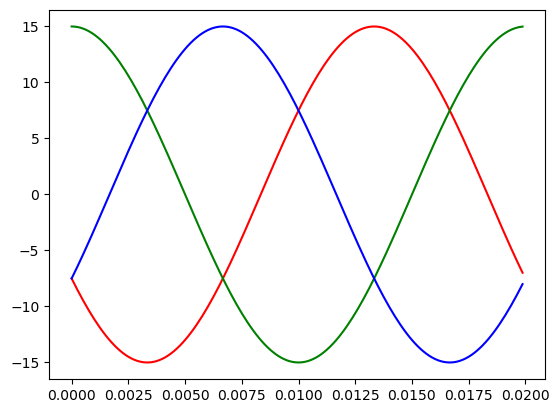

In [1]:
import nest_asyncio
nest_asyncio.apply()
import umbridge
import numpy as np
import matplotlib.pyplot as plt

#model = umbridge.HTTPModel("http://localhost:4242","MODEL_NAME")

#Define time interval
t = np.arange(0,20e-3,125e-6) 

omega_AC = 2*np.pi*50
I_AC = 15

def y_ref(t,k):
    return I_AC*np.cos(omega_AC*t-2*np.pi*(k-1)/3)

data=[]
for k in range (3):
    data.append([y_ref(val,k) for val in t])


fig,ax = plt.subplots()

ax.plot(t,data[0],color="red",label="k=1")
ax.plot(t,data[1],color="green",label="k=2")
ax.plot(t,data[2],color="blue",label="k=3")
plt.show()


In [2]:
from scipy.optimize import minimize, LinearConstraint
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import quad


# A matrix
def a(n,R_arm, R_DC, L_arm, L_DC, R_AC, L_AC):
    A = np.zeros((n,n))
    np.fill_diagonal(A, [0, -(R_arm+3*R_DC)/(L_arm+3*L_DC), -(R_arm)/(L_arm), -(R_arm)/(L_arm), -(R_arm+2*R_AC)/(L_arm+2*L_AC), -(R_arm+2*R_AC)/(L_arm+2*L_AC)])
    return A  

# B matrix
def b(n, L_arm, L_DC, L_AC):
    B = np.zeros((n, n))
    np.fill_diagonal(B, [0, -(1)/(L_arm+3*L_DC), -(1)/(L_arm), -(1)/(L_arm), -(1)/(L_arm+2*L_AC), -(1)/(L_arm+2*L_AC)])
    return B  


# F matrix
def f(n, L_arm, L_DC, L_AC):
    F = np.zeros((n , n -2))
    F[1][3] = (-(np.sqrt(6)))/(2*L_arm+6*L_DC)
    F[4][0] = (1/(L_arm+2*L_AC))
    F[4][1] = (-1/(L_arm+2*L_AC))
    F[5][0] = (np.sqrt(3)/(3*L_arm+6*L_AC))
    F[5][1] = (np.sqrt(3)/(3*L_arm+6*L_AC))
    F[5][2] = (-(np.sqrt(3))/(3*L_arm+6*L_AC))
    return F  

#C matrix
def c(n):
    C = np.zeros((n,n))
    C[0][0] = 2
    C[4][4] = 2
    C[5][5] = 2
    return C

# T matrix 
T = np.array( [[1/np.sqrt(6), 1/np.sqrt(6), 1/np.sqrt(6), 1/np.sqrt(6), 1/np.sqrt(6), 1/np.sqrt(6)],
                      [-1/np.sqrt(6), -1/np.sqrt(6), -1/np.sqrt(6), 1/np.sqrt(6), 1/np.sqrt(6), 1/np.sqrt(6)],
                      [1/2, -1/2, 0, -1/2, 1/2, 0],
                      [1/np.sqrt(12), 1/np.sqrt(12), -1/np.sqrt(3), -1/np.sqrt(12), -1/np.sqrt(12), 1/np.sqrt(3)],
                      [-1/2, 1/2, 0, -1/2, 1/2, 0],
                      [-1/np.sqrt(12), -1/np.sqrt(12), 1/np.sqrt(3), -1/np.sqrt(12), -1/np.sqrt(12), 1/np.sqrt(3)],
                     ])

# Define the input parameters according to the nominal values given in the version 3 of the paper
R_arm = 20e-3   # 20 mΩ, will vary in a 10 percent range
R_DC = 10e-3      # 10 mΩ, fix so it will not vary
R_AC = 60e-3    # 60 mΩ, will vary in a 10 percent range
L_arm = 200e-6  # 200 µH, will vary in a 10 percent range
L_DC = 5e-3      # 5 mH, fix so it will not vary
L_AC = 320e-3   # 320 mH, will vary in a 10 percent range
#u_parameters =  [599.3, 23.3, 427.5, 100.7, 676.7, 272.5]  # Values within the voltage constraint (<= 800V)
omega = 2*np.pi*50  # Example angular frequency (50 Hz)
I_AC = 15
U_AC = 700
U_DC = 325

def control_vector_without_phases(t, p):
    u1 = p[0] + p[1]*np.sin(2*np.pi*p[2]*t) + p[3]*np.cos(2*np.pi*p[4]*t)
    u2 = p[5] + p[6]*np.sin(2*np.pi*p[7]*t) + p[8]*np.cos(2*np.pi*p[9]*t)
    u3 = p[10] + p[11]*np.sin(2*np.pi*p[12]*t) + p[13]*np.cos(2*np.pi*p[14]*t)
    u4 = p[15] + p[16]*np.sin(2*np.pi*p[17]*t) + p[18]*np.cos(2*np.pi*p[19]*t)
    u5 = p[20] + p[21]*np.sin(2*np.pi*p[22]*t) + p[23]*np.cos(2*np.pi*p[24]*t)
    u6 = p[25] + p[26]*np.sin(2*np.pi*p[27]*t) + p[28]*np.cos(2*np.pi*p[29]*t)
        
    return np.array([u1, u2, u3, u4, u5, u6])

def control_vector(t, p):
    u1 = p[0] + p[1]*np.sin(2*np.pi*(p[2]*t + p[3])) + p[4]*np.cos(2*np.pi*(p[5]*t + p[6]))
    u2 = p[7] + p[8]*np.sin(2*np.pi*(p[9]*t + p[10])) + p[11]*np.cos(2*np.pi*(p[12]*t + p[13]))
    u3 = p[14] + p[15]*np.sin(2*np.pi*(p[16]*t + p[17])) + p[18]*np.cos(2*np.pi*(p[19]*t + p[20]))
    u4 = p[21] + p[22]*np.sin(2*np.pi*(p[23]*t + p[24])) + p[25]*np.cos(2*np.pi*(p[26]*t + p[27]))
    u5 = p[28] + p[29]*np.sin(2*np.pi*(p[30]*t + p[31])) + p[32]*np.cos(2*np.pi*(p[33]*t + p[34]))
    u6 = p[35] + p[36]*np.sin(2*np.pi*(p[37]*t + p[38])) + p[39]*np.cos(2*np.pi*(p[40]*t + p[41]))

    return np.array([u1, u2, u3, u4, u5, u6])


def disturbance_vector(t, omega_AC, U_AC, U_DC):
    z = []
    for k in range(3):
        z.append(U_AC * np.cos (omega_AC * t - (2 * np.pi * (k-1))/3))

    z.append(U_DC)
    return np.array(z)

# Define the reference solution for the output currents i_1...i_3, i.e. y_1...y_3
def y_reference(t,I_AC,omega_AC):
    y = []
    for k in range(3):
        y.append(I_AC*np.cos(omega_AC*t-2*np.pi*(k-1)/3))
    return np.array(y)

def MMC_ODE(t, x_tilde, p, A_tilde, B_tilde, F_tilde, T, omega_AC, U_AC, U_DC):
    u = control_vector_without_phases(t,p)
    z = disturbance_vector(t,omega_AC,U_AC,U_DC)
    dx_tildedt= A_tilde @ x_tilde + B_tilde @ (T @ u) + F_tilde @ z

    return dx_tildedt

def y_sol(p,x0, A_tilde, B_tilde, F_tilde, T, omega_AC, U_AC, U_DC,t_span=[0,20e-3],t_eval=np.arange(0,20e-3+125e-6,125e-6)):

    #Calculate x_tilde_1-6 -> shape (6,160)
    ode_sol = solve_ivp(MMC_ODE,t_span=t_span,y0=x0,method="RK45",t_eval=t_eval,args=(p,A_tilde,B_tilde,F_tilde,T,omega_AC,U_AC,U_DC))

    #return y vector to compare with y_ref
    x_tilde_sol = ode_sol.y
    y = np.array([-x_tilde_sol[4]-1/np.sqrt(3)*x_tilde_sol[5],x_tilde_sol[4]-1/np.sqrt(3)*x_tilde_sol[5],2/np.sqrt(3)*x_tilde_sol[5]])

    return y






In [3]:
#Define inital values for the parameters of the control vector u
u0 = [599.3, 23.3, 427.5, 100.7, 676.7, 272.5]
p_initial = np.array([599.3/2,0,50,0,599.3/2,50,0,
             23.3/2,0,50,0,23.3/2,50,0,
             427.5/2,0,50,0,427.5/2,50,0,
             100.7/2,0,50,0,100.7/2,50,0,
             676.7/2,0,50,0,676.7/2,50,0,
             272.5/2,0,50,0,272.5/2,50,0])

#Define inital values for x_tilde
x_tilde0 = np.array([0,0,0,0,0,0])

#Define matrices
A = a(n=6,R_arm=R_arm,R_DC=R_DC,L_arm=L_arm,L_DC=L_DC,R_AC=R_AC,L_AC=L_AC)
B = b(n=6,L_arm=L_arm,L_DC=L_DC,L_AC=L_AC)
F = f(n=6,L_arm=L_arm,L_DC=L_DC,L_AC=L_AC)
C = c(n=6)

#Define time interval in which the ODE is to be solved and the time steps at which it is to be evaluated
t_start,t_stop,t_step = 0,20e-3,125e-6
t_eval = np.arange(t_start,t_stop+t_step,t_step)
t_span = [t_eval[0],t_eval[-1]]

#Solve the ODE for these parameters
y_sol_test = y_sol(p=p_initial,x0=x_tilde0,A_tilde=A,B_tilde=B,F_tilde=F,T=T,omega_AC=omega,U_AC=U_AC,U_DC=U_DC,t_span=t_span,t_eval=t_eval)

In [4]:
#Do optimisation procedure to find optimal parameters p[0]...p[29] to match y from y_sol with y_ref
def objective_function(p, x0, A_tilde, B_tilde, F_tilde, T, omega_AC, U_AC, U_DC,t_span,t_eval,y_ref):
    """
    Calculate the MSE between the actual output of the MMC and the desired y_ref
    """
    y_out = y_sol(p, x0, A_tilde, B_tilde, F_tilde, T, omega_AC, U_AC, U_DC,t_span,t_eval)

    #Calculate mse. Cautious: the shape returned by y_sol is (160,3), i.e. not the normal way of defining vectors. Thus, transpose it to compare it to y_ref
    mse = np.mean((y_out.T-y_ref)**2)
    return mse

#Define reference vector 
y_ref = np.array([y_reference(t,I_AC=I_AC,omega_AC=omega) for t in t_eval])


#Implement constraints 
def arm_powers(x_tilde,T,p,t_eval):
    """
    Calculate the arm powers for the numerically determined x_tilde_1..x_tilde_6 at the same t_eval points
    """
    u = control_vector(t,p)
    u_t = np.array([u(t,p) for t in t_eval])
    x_tilde_power = np.multiply(T.T @ (T @ u_t), T.T @ x_tilde) 
    return x_tilde_power


def constraint_arm_power(p,x0,A_tilde,B_tilde,F_tilde,omega_AC,U_AC,U_DC,upper_bound,t_span,t_eval):
    """
    Define constraint on arm powers, i.e. derivatives of x_7...x_12. That is, they must not exceed 5 kW
    """
    #Solve ode
    sol = solve_ivp(MMC_ODE,t_span=t_span,y0=x0,method="RK45",t_eval=t_eval,args=(p,A_tilde,B_tilde,F_tilde,T,omega_AC,U_AC,U_DC))
    x_tilde_sol = sol.y

    #Calculate arm powers
    x_tilde_power = arm_powers(x_tilde_sol,T,p,t_eval)

    #Enforce that x_tilde_power is within the specified bounds
    return upper_bound-x_tilde_power


#Define upper bounds for constraints
arm_powers_upper_bound = 5e3 #in W
control_vector_upper_bound = 800 #in V

#Define constraints
#constraints = {"type": "ineq","fun":constraint_arm_power, "args":(x_tilde0,A,B,F,omega,U_AC,U_DC,arm_powers_upper_bound,t_span,t_eval),
 #             "type": "ineq","fun":constraint_control_vector,"args":(t_eval,control_vector_upper_bound)}

def create_shifted_matrix(p_initial, x_initial):
    # Get the lengths of the input lists
    n_rows = len(x_initial)
    n_columns = len(p_initial)  # Assuming square matrix based on your description
    n_ones = int(n_columns/n_rows)
    
    # Create an empty matrix filled with zeros
    matrix = np.zeros((n_rows, n_columns), dtype=int)
    
    # Fill the matrix with shifting 1s
    for i in range(n_rows):
        start_index = i * int(n_columns/n_rows)  # Calculate the starting index for the current row
        for j in range(n_ones):
            matrix[i][(start_index + j) % int(n_columns)] = 1
            
    return matrix

linear_constraint = LinearConstraint(create_shifted_matrix(p_initial,x_tilde0),-800,800)

# Perform optimization to minimize the objective function
p_result = minimize(objective_function, x0=p_initial, args=(x_tilde0, A, B, F, T, omega, U_AC, U_DC,t_span,t_eval, y_ref),constraints=[linear_constraint],method='SLSQP')

[  85.59096291 -143.42659876 -104.67301835  -82.0726504    85.42474981
 -102.58441148 -194.02323248   12.127668   -146.46416061   59.28687776
 -102.15396138 -313.88775327   52.90239952  -20.98002168  191.87978858
   -6.51632466   68.84084419  -30.22264336  468.47906145   42.71504165
   64.82423183  223.3583676    42.32521718  135.38083482    0.
  -49.40247653  123.30483069   19.11306527  238.59752347    0.
   50.            0.          338.35         50.            0.
  136.25          0.           50.            0.          136.25
   50.            0.        ]
[[-0.00000000e+00  1.02984742e-01  2.11851851e-01  3.26426036e-01
   4.46530592e-01  5.71987505e-01  7.02617160e-01  8.38236840e-01
   9.78660764e-01  1.12370010e+00  1.27316296e+00  1.42685439e+00
   1.58457642e+00  1.74612798e+00  1.91130497e+00  2.07990025e+00
   2.25170360e+00  2.42650175e+00  2.60407839e+00  2.78421416e+00
   2.96668663e+00  3.15127031e+00  3.33773669e+00  3.52585417e+00
   3.71539242e+00  3.90612874e+00  4

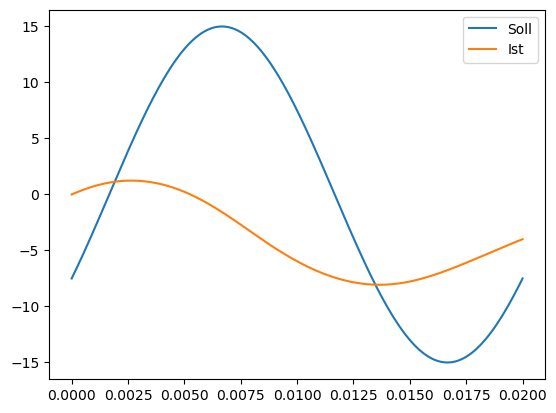

In [5]:
#save optimised parameters
p_optimised = p_result.x
print(p_optimised)

#Compare y calculated with control vector with optimised parameters to y_ref
y_sol_optimised_p = y_sol(p=p_optimised,x0=x_tilde0,A_tilde=A,B_tilde=B,F_tilde=F,T=T,omega_AC=omega,U_AC=U_AC,U_DC=U_DC)
print(y_sol_optimised_p)

#Plot solution
plt.plot(t_eval,[y_reference(t,I_AC=I_AC,omega_AC=omega)[2] for t in t_eval],label="Soll")
plt.plot(t_eval,y_sol_optimised_p[2],label="Ist")
plt.legend()

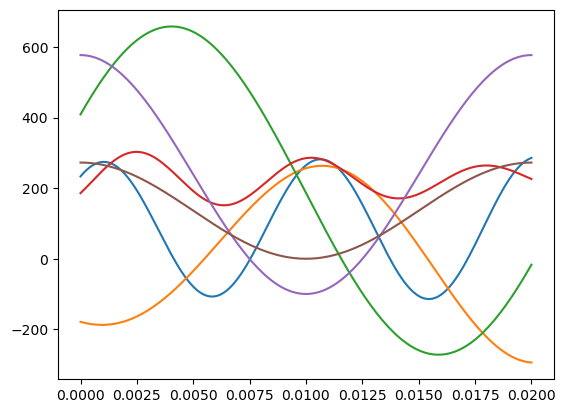

In [6]:
plt.plot(t_eval,[control_vector(t,p_optimised) for t in t_eval])

In [7]:
# Set the mean values for the parameters
mean_R_arm = R_arm   # 20e-3 (20 mΩ)
mean_R_AC = R_AC     # 60e-3 (60 mΩ)
mean_L_arm = L_arm   # 200e-6 (200 µH)
mean_L_AC = L_AC     # 320e-3 (320 mH)

# Set the standard deviation for the Gaussian perturbation (10% of the mean)
std_dev_R_arm = 0.1 * mean_R_arm
std_dev_R_AC = 0.1 * mean_R_AC
std_dev_L_arm = 0.1 * mean_L_arm
std_dev_L_AC = 0.1 * mean_L_AC

# Run the simulation 100 times with random variations
num_simulations = 100
results = []

for i in range(num_simulations):
    # Generate random values for R_arm, R_AC, L_arm, L_AC within ±10% of their mean
    R_arm_varied = np.random.normal(mean_R_arm, std_dev_R_arm)
    R_AC_varied = np.random.normal(mean_R_AC, std_dev_R_AC)
    L_arm_varied = np.random.normal(mean_L_arm, std_dev_L_arm)
    L_AC_varied = np.random.normal(mean_L_AC, std_dev_L_AC)

    # Redefine A, B, F matrices with the new perturbed values
    A_varied = a(n=6, R_arm=R_arm_varied, R_DC=R_DC, L_arm=L_arm_varied, L_DC=L_DC, R_AC=R_AC_varied, L_AC=L_AC_varied)
    B_varied = b(n=6, L_arm=L_arm_varied, L_DC=L_DC, L_AC=L_AC_varied)
    F_varied = f(n=6, L_arm=L_arm_varied, L_DC=L_DC, L_AC=L_AC_varied)

    # Solve the ODE for these parameters
    y_sol_varied = y_sol(p=p_optimised, x0=x_tilde0, A_tilde=A_varied, B_tilde=B_varied, F_tilde=F_varied, 
                         T=T, omega_AC=omega, U_AC=U_AC, U_DC=U_DC, t_span=t_span, t_eval=t_eval)

    # Store the result for further analysis (you can store more details as needed)
    results.append(y_sol_varied)

    # Optionally: Print or analyze each result (or you could store it for further processing)
    print(f"Simulation {i+1} completed")
print(results)
# After 100 simulations, results will contain all the varied outputs
# You can now analyze or visualize the results as needed

#TO-DO: Calculate the MC Mean for each output, print out mean of the y's,  

Simulation 1 completed
Simulation 2 completed
Simulation 3 completed
Simulation 4 completed
Simulation 5 completed
Simulation 6 completed
Simulation 7 completed
Simulation 8 completed
Simulation 9 completed
Simulation 10 completed
Simulation 11 completed
Simulation 12 completed
Simulation 13 completed
Simulation 14 completed
Simulation 15 completed
Simulation 16 completed
Simulation 17 completed
Simulation 18 completed
Simulation 19 completed
Simulation 20 completed
Simulation 21 completed
Simulation 22 completed
Simulation 23 completed
Simulation 24 completed
Simulation 25 completed
Simulation 26 completed
Simulation 27 completed
Simulation 28 completed
Simulation 29 completed
Simulation 30 completed
Simulation 31 completed
Simulation 32 completed
Simulation 33 completed
Simulation 34 completed
Simulation 35 completed
Simulation 36 completed
Simulation 37 completed
Simulation 38 completed
Simulation 39 completed
Simulation 40 completed
Simulation 41 completed
Simulation 42 completed
S

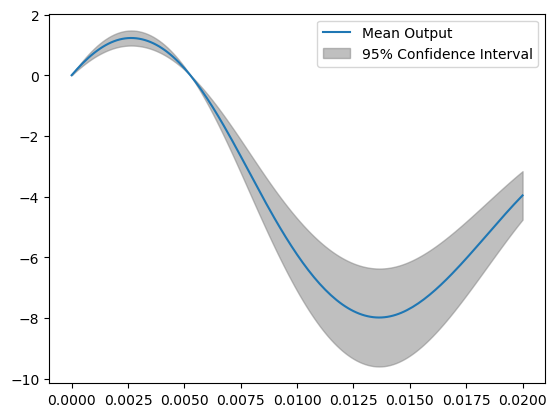

In [8]:
# Convert results to numpy array for easier analysis
mc_results = np.array(results)

# Calculate mean and standard deviation across all samples for y[2] (as an example)
mean_output = np.mean(mc_results[:, 2, :], axis=0)
std_output = np.std(mc_results[:, 2, :], axis=0)

# Plot mean and confidence interval
plt.plot(t_eval, mean_output, label="Mean Output")
plt.fill_between(t_eval, mean_output - 2*std_output, mean_output + 2*std_output, 
                 color='gray', alpha=0.5, label="95% Confidence Interval")
plt.legend()
plt.show()


$$\text{Post-simulation analysis}$$

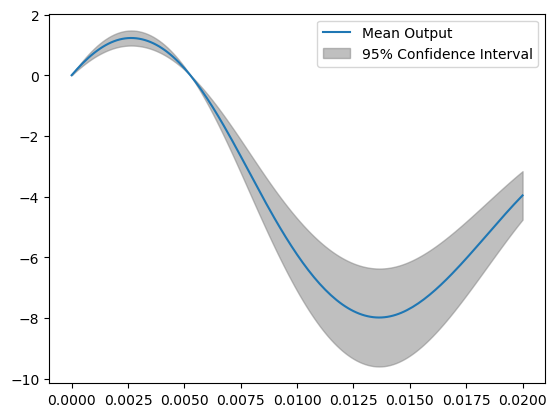

In [9]:
# Convert results to numpy array for easier analysis
mc_results = np.array(mc_results)

# Calculate mean and standard deviation across all samples for y[2] (as an example)
mean_output = np.mean(mc_results[:, 2, :], axis=0)
std_output = np.std(mc_results[:, 2, :], axis=0)

# Plot mean and confidence interval
plt.plot(t_eval, mean_output, label="Mean Output")
plt.fill_between(t_eval, mean_output - 2*std_output, mean_output + 2*std_output, 
                 color='gray', alpha=0.5, label="95% Confidence Interval")
plt.legend()
plt.show()


In [10]:
pip install SALib

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


$$\text{Sobol analysis}$$

In [13]:
from SALib.sample import saltelli
from SALib.analyze import sobol
import numpy as np

# Predefined constants and parameters
mean_R_arm = R_arm   # Mean value for R_arm
mean_R_AC = R_AC     # Mean value for R_AC
mean_L_arm = L_arm   # Mean value for L_arm
mean_L_AC = L_AC     # Mean value for L_AC

# Assume p_initial, x_tilde0, T, omega_AC, U_AC, U_DC, t_span, t_eval are already defined

# Define the Sobol sensitivity analysis problem
problem = {
    'num_vars': 4,
    'names': ['R_arm', 'R_AC', 'L_arm', 'L_AC'],
    'bounds': [
        [mean_R_arm * (1 - 0.1), mean_R_arm * (1 + 0.1)],  # R_arm range
        [mean_R_AC * (1 - 0.1), mean_R_AC * (1 + 0.1)],    # R_AC range
        [mean_L_arm * (1 - 0.1), mean_L_arm * (1 + 0.1)],  # L_arm range
        [mean_L_AC * (1 - 0.1), mean_L_AC * (1 + 0.1)]     # L_AC range
    ]
}

# Function to run the model with the given parameters
def run_model(R_arm_val, R_AC_val, L_arm_val, L_AC_val):
    # Redefine matrices A, B, F based on the sampled parameter values
    A = a(n=6, R_arm=R_arm_val, R_DC=R_DC, L_arm=L_arm_val, L_DC=L_DC, R_AC=R_AC_val, L_AC=L_AC_val)
    B = b(n=6, L_arm=L_arm_val, L_DC=L_DC, L_AC=L_AC_val)
    F = f(n=6, L_arm=L_arm_val, L_DC=L_DC, L_AC=L_AC_val)

    # Solve the ODE with these parameters
    y_solution = y_sol(p=p_initial, x0=x_tilde0, A_tilde=A, B_tilde=B, F_tilde=F,
                       T=T, omega_AC=omega_AC, U_AC=U_AC, U_DC=U_DC, t_span=t_span, t_eval=t_eval)
    
    # Return the output at the final time step (for example y[2] at the final time step)
    return y_solution

# Generate samples using the Saltelli sampling scheme
param_values = saltelli.sample(problem, 1000)

# Run the model for each sampled set of parameters and extract the desired output (e.g., y[2, -1])
Y = np.array([run_model(R_arm_val, R_AC_val, L_arm_val, L_AC_val)[2, -1]  
              for R_arm_val, R_AC_val, L_arm_val, L_AC_val in param_values])

# Perform Sobol analysis
Si = sobol.analyze(problem, Y)

# Print Sobol indices
print("Sobol first-order indices:", Si['S1'])
print("Sobol total-order indices:", Si['ST'])


/var/folders/xt/zf0l90k91ks5gwsbsjtnkxr00000gn/T/ipykernel_11584/905425973.py:40: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5.1 Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 1000)


Sobol first-order indices: [ 1.58865300e-06  5.28467002e-05 -1.41417216e-06  9.98613135e-01]
Sobol total-order indices: [6.96759891e-07 3.43281526e-05 4.38045606e-06 9.98685801e-01]


/Users/marencordts/anaconda3/lib/python3.10/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
